# DSCI 100 Group 7 Project Report
## Classification of Video Game Genres Based On Sales in Different Regions
##### Group Members: Alison Wai, Charlie Li, Sandro Xu & Qingyue Guo

### Introduction

PlayStation 4 (PS4) is a video game console that was released by Sony Interactive Entertainment in 2013 (Gao <i>et al.</i> 206-214). This console has been very popular since its release, with over 10 million consoles in circulation worldwide (Davies <i>et al.</i> S81-S89). Countless games of different genres have also been released with varying levels of sales success. We wanted to explore this topic further by examining how successful each genre has been, so we searched on Kaggle, an online data science community, for relevant datasets. Eventually, we found a dataset about Playstation 4 video game sales that was created in 2019 by a Kaggle user named SID_TWR, who obtained the data by web scraping from Metacritic, a game review website. They were inspired by another user that scraped a different website to create a large video game sales dataset that included games from any platform that sold more than 100,000 copies. The PS4 dataset includes 9 columns of categorical and numerical variables, including the game name, year of publication, genre, publisher, North America sales, Europe sales, Japan sales, rest of the world sales, and total global sales. Each of the sales columns are measured in units of millions of copies. There are 1031 observations in the original dataset. Using this dataset information, we will try to answer the following question: “If we create a new PS4 game with the goal of selling at least 1 million copies in North America and at least 1 million copies in Europe, what genre of game should we release?” Because we are trying to predict a categorical variable based on numeric variables, our approach to answering this question is with a $K$-nearest neighbor classification model.

### Methods & Results

Load the required packages.

In [2]:
library(tidyverse)
library(rvest)
library(digest)
library(repr)
library(tidymodels)
library(tidyr)
library(knitr)
library(RColorBrewer)
options(repr.matrix.max.rows = 6)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘rvest’ was built under R version 4.0.2”
Loading required package: xml2


Attaching package: ‘rvest’


The following object is masked from ‘package:purrr’:

    pluck


The following object is masked from ‘package:readr’:

    guess_encoding


Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
─

First, we will read the PS4 video game sales dataset downloaded from Kaggle and uploaded to GitHub into `video_game_raw`. Then, we will remove any rows that have missing values and store the cleaned up dataset into `video_game`. 

In [3]:
# read the csv
video_game_raw <- read_csv("https://raw.githubusercontent.com/charlie-li-02/dsci_100_data/main/PS4_GamesSales.csv")

# remove the NAs
video_game <- na.omit(video_game_raw)

raw_rows <- nrow(video_game_raw)
cleaned_rows <- nrow(video_game)
removed_rows <- raw_rows - cleaned_rows
removed_rows

# getting 6 rows for the raw video game data set and 6 rows for the cleaned video game data set 
video_game_raw_head <- head(video_game_raw, 3)
video_game_raw_tail <- tail(video_game_raw, 3)
video_game_raw_preview <- rbind(video_game_raw_head, video_game_raw_tail)
video_game_head <- head(video_game, 3)
video_game_tail <- tail(video_game, 3)
video_game_preview <- rbind(video_game_head, video_game_tail)

# turn the data into a table
kable(video_game_raw_preview, "simple", caption = "2.1 Preview of raw dataset downloaded from Kaggle")
kable(video_game_preview, "simple", caption = "2.2 Preview of cleaned up dataset")

Parsed with column specification:
cols(
  Game = col_character(),
  Year = col_character(),
  Genre = col_character(),
  Publisher = col_character(),
  `North America` = col_double(),
  Europe = col_double(),
  Japan = col_double(),
  `Rest of World` = col_double(),
  Global = col_double()
)



[1] 209



Table: 2.1 Preview of raw dataset downloaded from Kaggle

Game                         Year   Genre              Publisher         North America   Europe   Japan   Rest of World   Global
---------------------------  -----  -----------------  ---------------  --------------  -------  ------  --------------  -------
Grand Theft Auto V           2014   Action             Rockstar Games             6.06     9.71    0.60            3.02    19.39
Call of Duty: Black Ops 3    2015   Shooter            Activision                 6.18     6.05    0.41            2.44    15.09
Red Dead Redemption 2        2018   Action-Adventure   Rockstar Games             5.26     6.21    0.21            2.26    13.94
The Mummy Demastered         N/A    Action             NA                         0.00     0.00    0.00            0.00     0.00
Project Nimbus: Code Mirai   N/A    Action             NA                         0.00     0.00    0.00            0.00     0.00
Battle Chef Brigade          N/A    A



Table: 2.2 Preview of cleaned up dataset

Game                        Year   Genre              Publisher                     North America   Europe   Japan   Rest of World   Global
--------------------------  -----  -----------------  ---------------------------  --------------  -------  ------  --------------  -------
Grand Theft Auto V          2014   Action             Rockstar Games                         6.06     9.71    0.60            3.02    19.39
Call of Duty: Black Ops 3   2015   Shooter            Activision                             6.18     6.05    0.41            2.44    15.09
Red Dead Redemption 2       2018   Action-Adventure   Rockstar Games                         5.26     6.21    0.21            2.26    13.94
Chaos on Deponia            2017   Adventure          Daedalic Entertainment                 0.00     0.00    0.00            0.00     0.00
Code Vein                   2018   Action             Bandai Namco Entertainment             0.00     0.00    0.00  

From the printout above, we can see that 209 rows of the dataset have been removed because they have missing values. By comparing table 2.1 and table 2.2, we can see that the rows containing `N/A` have been removed.

Our goal is to find out what video game genre to choose if we want to create a new video game and sell at least 1 million copies in both North America and Europe. With our dataset, we can try to answer this question by visualizing the data with a bar plot that compares the genre and its average copies sold in the two regions.

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)



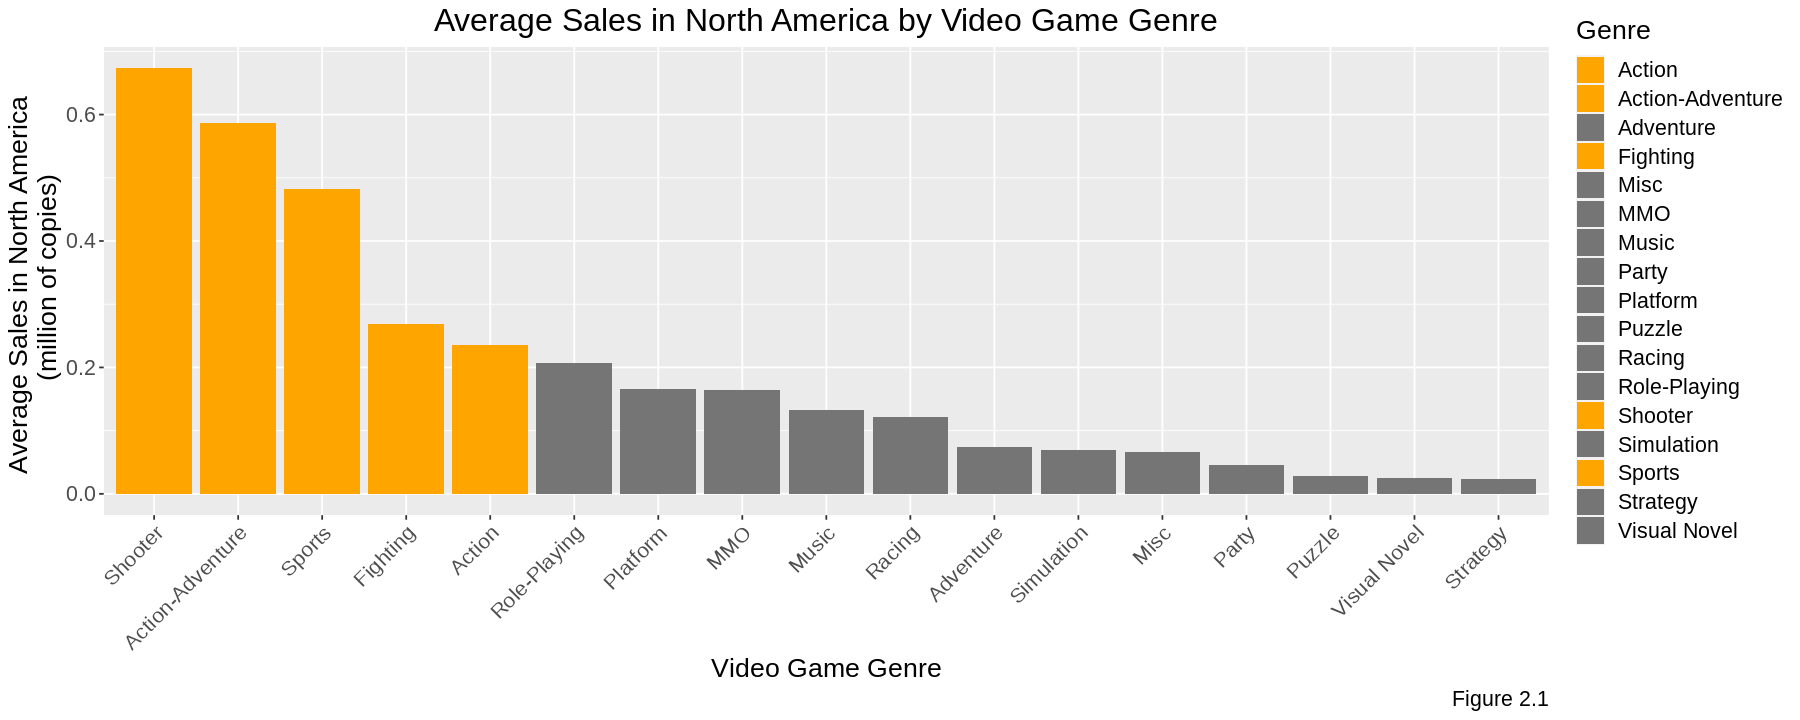

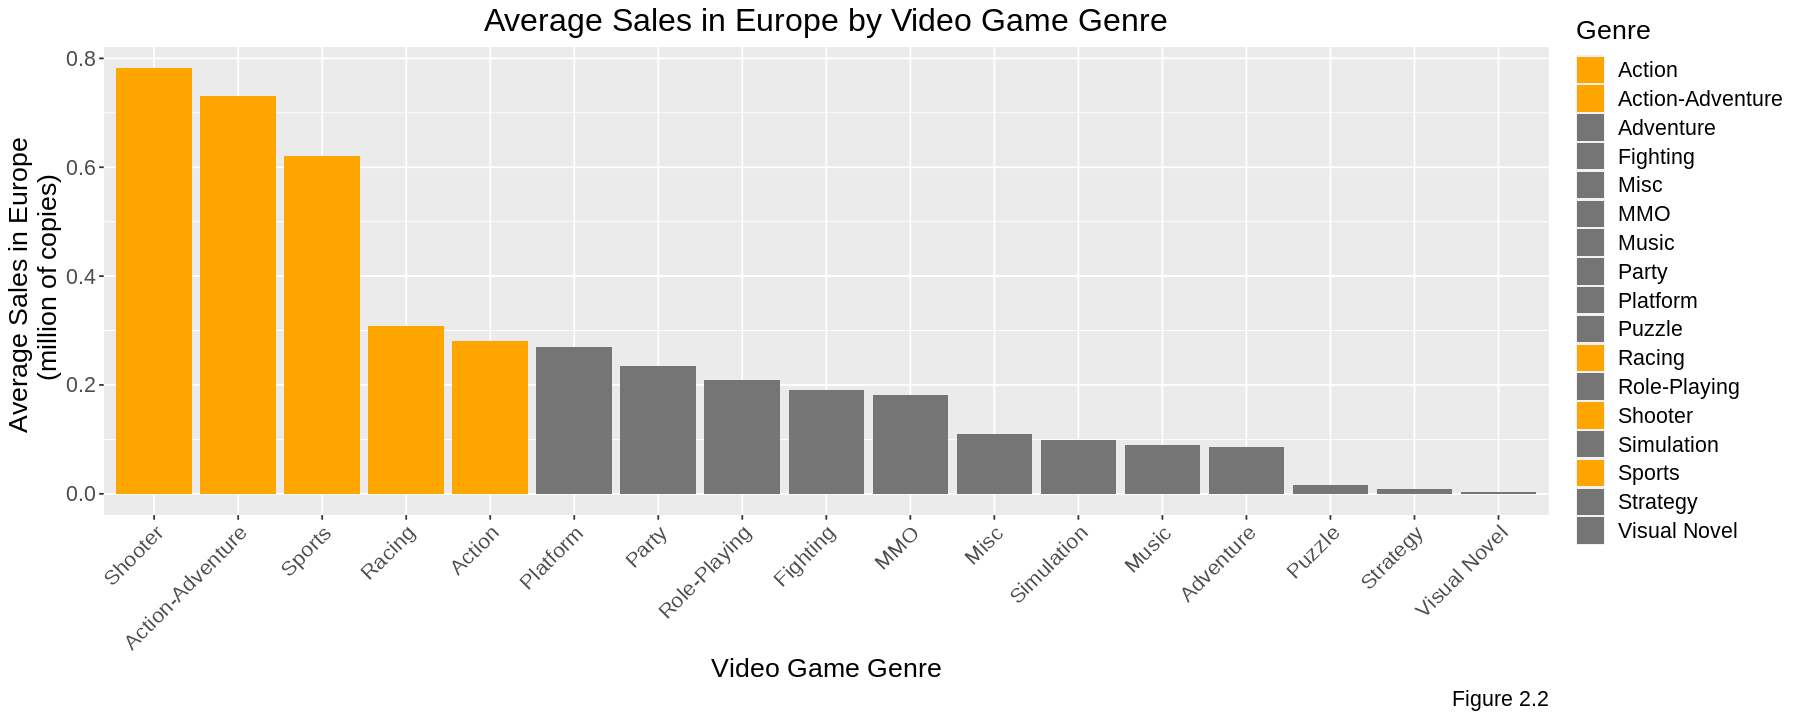

In [4]:
# compute the mean sale for every genre of games in the North America region
video_game_na_mean <- video_game %>%
    group_by(Genre) %>%
    summarize(North_America = mean(`North America`))

# generate the mean sale for every genre of games in the Europe region
video_game_eu_mean <- video_game %>%
    group_by(Genre) %>%
    summarize(Europe = mean(Europe))

# generate a bar plot by highlighting the genres with the top 5 average game sales for the North America region
options(repr.plot.width = 15, repr.plot.height = 6)
video_game_na_plot <- ggplot(video_game_na_mean, aes(x = fct_reorder(Genre, North_America, .desc = TRUE), 
                                                              y = North_America, fill = Genre)) + 
    geom_bar(stat = "identity") + 
    scale_fill_manual(values = c("orange", "orange", "grey46", "orange", "grey46", "grey46", 
                                 "grey46", "grey46", "grey46", "grey46", "grey46", "grey46", 
                                 "orange", "grey46", "orange", "grey46", "grey46")) +
    labs(x = "Video Game Genre", 
         y = "Average Sales in North America \n (million of copies)", 
         title = "Average Sales in North America by Video Game Genre",
         caption = "Figure 2.1") +
    theme(text = element_text(size = 16), 
          axis.text.x = element_text(angle = 45, hjust = 1), 
          plot.title = element_text(hjust = 0.5))
video_game_na_plot

# generate a bar plot by highlighting the genres with the top 5 average game sales for the Europe region
video_game_eu_plot <- ggplot(video_game_eu_mean, aes(x = fct_reorder(Genre, Europe, .desc = TRUE), 
                                                              y = Europe, fill = Genre)) + 
    geom_bar(stat = "identity") +  
    scale_fill_manual(values = c("orange", "orange", "grey46", "grey46", "grey46", "grey46", 
                                 "grey46", "grey46", "grey46", "grey46", "orange", "grey46", 
                                 "orange", "grey46", "orange", "grey46", "grey46")) +
    labs(x = "Video Game Genre", 
         y = "Average Sales in Europe \n (million of copies)", 
         title = "Average Sales in Europe by Video Game Genre",
         caption = "Figure 2.2") +
    theme(text = element_text(size = 16), 
          axis.text.x = element_text(angle = 45, hjust = 1), 
          plot.title = element_text(hjust = 0.5))
video_game_eu_plot

From figures 2.1 and 2.2, we can see that even though shooter games generally do well in both North America and Europe, neither of the plots actually have sales averages that reach 1 million copies. And thus, we cannot be sure that shooter games have a high average because they do well, or simply because more shooter games have been published. Furthermore, we cannot conclude that our only option is to create a shooter game to have our new video game sell 1 million copies in both North America and Europe. To better answer our original question, we need to use classification with the $K$-nearest neighbors algorithm. 

To create a $K$-nearest neighbor classifier, we need to wrangle our dataset to optimize the accuracy and relevancy of our classifier. First, we will rename the `North America` column to `North_America` so we can refer to it more easily and mutate the `Genre` variable to a factor so we can perform classification on it. Then, we will filter for the video games that have more than 100,000 sales globally. We do this because our question is "Which video game genre will most likely sell at least 1 million copies in both North America and Europe?" The games that have sold less than 100,000 copies globally will not have much influence on our results. We will also filter out any games published before 2013, since we want a more up-to-date dataset to predict more accurately. After that, we will select the `Genre`, `North_America`, and `Europe` columns to perform our data analysis, because those are the only columns that we are interested in. And since this dataset contains a large number of genres, a classifier created without filtering out the less popular genres would have a low accuracy and the scatter plot created would be difficult to read. To rectify this issue, we will filter for the coloured genres (`Shooter`, `Action-Adventure`, `Sports`, `Fighting`, `Racing`, and `Action`) in figures 2.1 and 2.2 to use in our classifier. Below is a preview of the dataset after wrangling. 

In [5]:
# filter and clean the data to extract relevant columns and rows based on the previous description
video_game_filtered <- video_game %>%
    rename("North_America" = "North America") %>% 
    mutate(Genre = as_factor(Genre)) %>%
    filter(Global >= 0.1, Year >= 2013) %>% 
    select(Genre, North_America, Europe) %>%
    filter(Genre %in% c("Shooter", "Action-Adventure", "Sports", "Fighting", "Racing", "Action"))

# display a preview of the resutls
kable(head(video_game_filtered, 6), "simple", 
      caption = "2.3 Preview of filtered dataset containing only the Genre, North America, and Europe columns, as well as only the top 5 genres in both regions")



Table: 2.3 Preview of filtered dataset containing only the Genre, North America, and Europe columns, as well as only the top 5 genres in both regions

Genre               North_America   Europe
-----------------  --------------  -------
Action                       6.06     9.71
Shooter                      6.18     6.05
Action-Adventure             5.26     6.21
Shooter                      4.67     6.21
Sports                       1.27     8.64
Sports                       1.26     7.95

We will set the seed to make sure our data analysis is reproducible. Then, we will split the dataset into a training set and a testing set, with 75% of the data in the training set and 25% in the testing set. We do this so we can perform cross-validation on the training set to optimize our choice of $K$, then create a model with the optimal $K$, and lastly fit the model on the testing set and evaluate its accuracy. 

In [6]:
set.seed(1)

# splitting data into training and testing sets
video_game_split <- initial_split(video_game_filtered, prop = 0.75, strata = Genre)
video_game_train <- training(video_game_split)
video_game_test <- testing(video_game_split)

Now we will begin creating the $K$-nearest neighbors classifier. We want to perform a cross-validation, so we will first create a `video_game_vfold` object specifying that we want to perform 10-fold cross-validation on the training set. This is because 10-fold cross-validation generally can reduce the standard error compared to 5-fold cross-validation, and will not take too long to run. We will also set the `strata` argument to `Genre` to have a more even distribution of the different genres in each validation set. We will set the seed here as well to make sure the analysis is reproducible.

In [7]:
set.seed(1)

video_game_vfold <- vfold_cv(video_game_train, v = 10, strata = Genre)

Next, we will create a model specifying that we want to tune the value of $K$ and set the mode to `classification`.

In [8]:
knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
    set_engine("kknn") %>%
    set_mode("classification")

Then, we will create a recipe with `Genre` being the target and `North_America` and `Europe` being the predictors. We will also standardize the data to make sure that both predictors have an equal amount of influence on the predicted result. 

In [9]:
video_game_recipe <- recipe(Genre ~ North_America + Europe, data = video_game_train) %>%
                       step_scale(all_predictors()) %>%
                       step_center(all_predictors())

We will create a workflow next, add `video_game_recipe` and `knn_tune` to the recipe and model, and use `video_game_vfold` to perform the cross-validation on 10 different values of $K$. Lastly, we will collect the metrics so we can see which $K$ value has the highest accuracy. Once again we will set the seed so our analysis is reproducible.

In [10]:
set.seed(1)

knn_results <- workflow() %>%
      add_recipe(video_game_recipe) %>%
      add_model(knn_tune) %>%
      tune_grid(resamples = video_game_vfold, grid = 10) %>%
      collect_metrics()

! Fold01: internal: No observations were detected in `truth` for level(s): 'Role-P...

! Fold02: internal: No observations were detected in `truth` for level(s): 'Role-P...

! Fold03: internal: No observations were detected in `truth` for level(s): 'Role-P...

! Fold04: internal: No observations were detected in `truth` for level(s): 'Role-P...

! Fold05: internal: No observations were detected in `truth` for level(s): 'Role-P...

! Fold06: internal: No observations were detected in `truth` for level(s): 'Role-P...

! Fold07: internal: No observations were detected in `truth` for level(s): 'Role-P...

! Fold08: internal: No observations were detected in `truth` for level(s): 'Role-P...

! Fold09: internal: No observations were detected in `truth` for level(s): 'Role-P...

! Fold10: internal: No observations were detected in `truth` for level(s): 'Action...



Now we will filter for the results and take a look at each $K$ value and its accuracy.

In [11]:
accuracies <- knn_results %>% 
      filter(.metric == "accuracy")
kable(accuracies, "simple", caption = "2.4 Number of neighbors and their accuracies")



Table: 2.4 Number of neighbors and their accuracies

 neighbors  .metric    .estimator         mean    n     std_err  .config 
----------  ---------  -----------  ----------  ---  ----------  --------
         2  accuracy   multiclass    0.3825311   10   0.0220039  Model01 
         3  accuracy   multiclass    0.4011293   10   0.0247056  Model02 
         5  accuracy   multiclass    0.4053148   10   0.0192917  Model03 
         6  accuracy   multiclass    0.3999577   10   0.0211043  Model04 
         7  accuracy   multiclass    0.4175983   10   0.0245376  Model05 
         9  accuracy   multiclass    0.4318841   10   0.0217144  Model06 
        10  accuracy   multiclass    0.4356366   10   0.0218813  Model07 
        12  accuracy   multiclass    0.4081098   10   0.0257323  Model08 
        13  accuracy   multiclass    0.4085239   10   0.0302366  Model09 
        15  accuracy   multiclass    0.3952475   10   0.0301320  Model10 

To better visualize which value of $K$ we should pick for our final model, we will create an accuracies vs $K$ plot to see which $K$ has the highest accuracy.

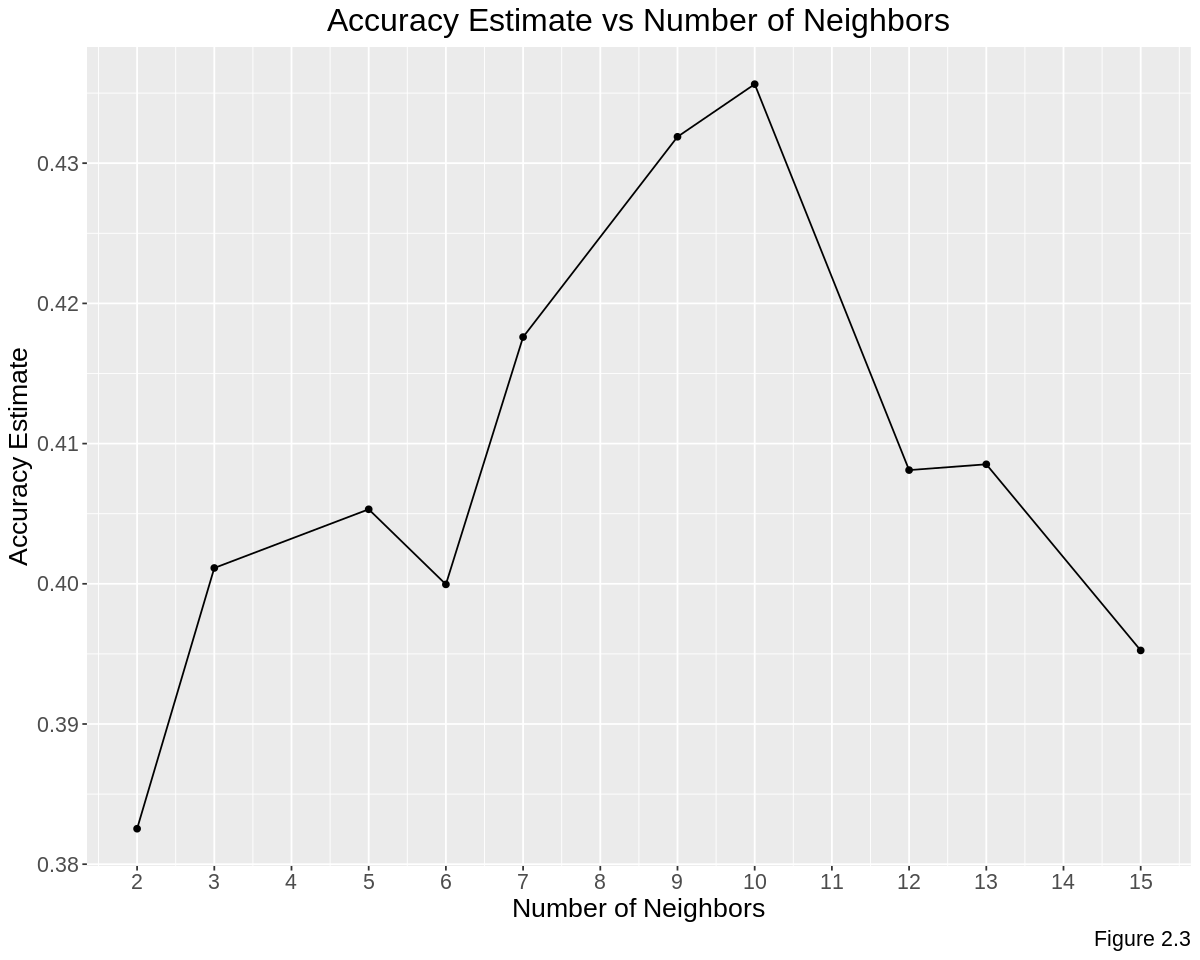

In [12]:
options(repr.plot.width = 10, repr.plot.height = 8)
accuracy_plot <- ggplot(accuracies, aes(x = neighbors, y = mean))+
    geom_point() +
    geom_line() +
    labs(x = "Number of Neighbors", 
         y = "Accuracy Estimate", 
         title = "Accuracy Estimate vs Number of Neighbors", 
         caption = "Figure 2.3") +
    scale_x_continuous(breaks = seq(0, 15, by = 1)) +
    theme(text = element_text(size = 16), 
          plot.title = element_text(hjust = 0.5)) 
accuracy_plot

From figure 2.3 above, we can see that $K = 10$ appears to have the highest accuracy, so we will create a new model specification with $K = 10$.

In [13]:
knn_best <- nearest_neighbor(weight_func = "rectangular", neighbors = 10) %>%
    set_engine("kknn") %>%
    set_mode("classification")

Then, we will create a workflow with the new model and reuse the old recipe, and fit the training set to create the classifier.

In [14]:
video_game_best_fit <- workflow() %>%
    add_recipe(video_game_recipe) %>%
    add_model(knn_best) %>%
    fit(data = video_game_train)

Lastly, we will use `predict()` on `video_game_best_fit` and the testing set to assess how well our classifier performs before we try to predict a new observation.

In [15]:
video_game_summary <- video_game_best_fit %>%
    predict(video_game_test) %>%
    bind_cols(video_game_test) %>%
    metrics(truth = Genre, estimate = .pred_class)
kable(video_game_summary, "simple", caption = "2.5 Metrics of the classifier's performance on the testing set")



Table: 2.5 Metrics of the classifier's performance on the testing set

.metric    .estimator    .estimate
---------  -----------  ----------
accuracy   multiclass    0.3472222
kap        multiclass    0.1358529

From table 2.5, we can see that the accuracy of our classifier is about 34.7% on the testing set. This is fairly inaccurate, but we can be confident that it is the highest accuracy we can produce with our dataset because we have optimized our choice of $K$ after we performed cross-validation on our dataset. The low accuracy could be due to the original data and the fact that some games would do significantly better in one region than in the other, even though the genre is the same. Regardless of the accuracy, we will try to classify a new observation and answer our initial question, "If we create a new PS4 game to sell at least 1 million copies in both North America and Europe, what genre of the game should we release?". We will create a tibble containing the new game of 1 million copies in both `North_America` and `Europe`.

In [16]:
new_game <- tibble(North_America = 1, Europe = 1)

Finally, we will predict the genre of the new video game.

In [17]:
video_game_predict <- predict(video_game_best_fit, new_game)
kable(video_game_predict, "simple", caption = "2.6 The prediction of the new video game's genre")



Table: 2.6 The prediction of the new video game's genre

|.pred_class |
|:-----------|
|Action      |

In table 2.6 above, we know that if we want our new video game to sell at least 1 million copies in both North America and Europe, we should create an action game.

Because of the classifier's low accuracy, we will create a scatter plot with the North America sales on the x-axis and the Europe sales on the y-axis, then plot our new observation on the plot to see if the predicted genre makes sense.

Warning message:
“Transformation introduced infinite values in continuous x-axis”
Warning message:
“Transformation introduced infinite values in continuous y-axis”


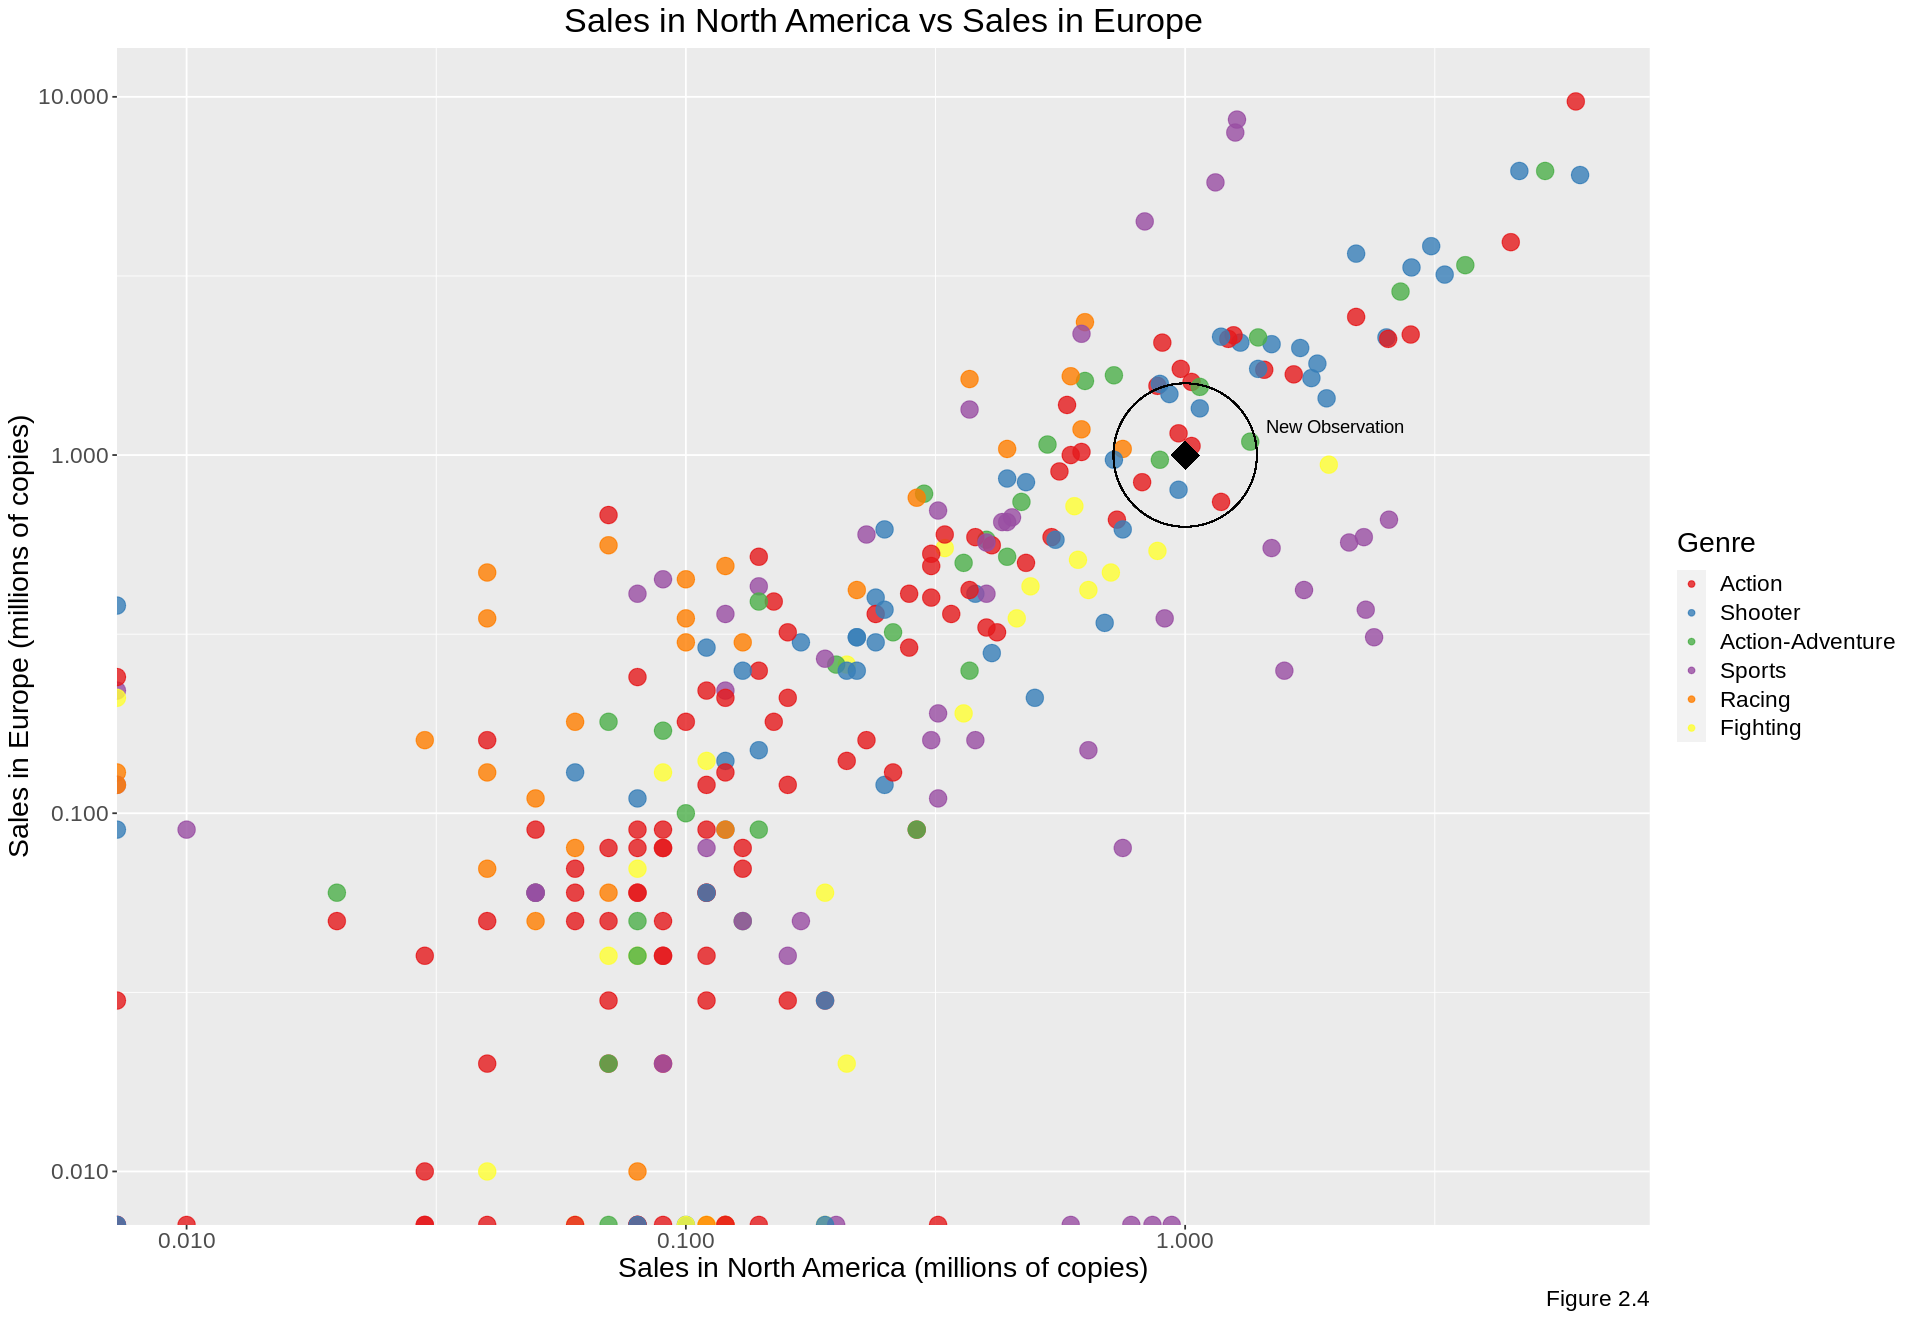

In [20]:
options(repr.plot.width = 16, repr.plot.height = 11)

new_game_plot <- ggplot(video_game_filtered, aes(x = North_America, y = Europe, 
                                                   color = Genre, size = 0.75)) +
    geom_point(alpha = 0.8) +
    geom_point(aes(x = 1, y = 1), color = "black", size = 8, shape = "diamond") + 
    geom_point(aes(x = 1, y = 1), color = "black", size = 40, pch = 1) + 
    scale_size(guide = "none") +
    labs(x = "Sales in North America (millions of copies)", 
         y = "Sales in Europe (millions of copies)", 
         color = "Genre",
         title = "Sales in North America vs Sales in Europe",
         caption = "Figure 2.4") +
    theme(text = element_text(size = 17), plot.title = element_text(hjust = 0.5)) +
    scale_x_log10(labels = label_comma()) +
    scale_y_log10(labels = label_comma()) +
    scale_color_brewer(palette = "Set1") +
    annotate("text", x = 2, y =  1.2, label = "New Observation")
new_game_plot

Looking at figure 2.4, we can say that there is a positive and linear relationship between Europe sales and North America sales. This implies that if the North American sale of a game is high, it will likely have a high number of copies sold in the European region as well. Additionally, the strength of the relationship is somewhere between moderate and strong. Furthermore, we can see that out of the 10 nearest neighbors (points that are encapsulated inside the black circle), there are 4 Action games (coloured in red), 3 Shooter games (coloured in blue), 2 Action-Adventure games (coloured in green), and 1 Racing game (coloured in orange). This makes Action games the mode of the 10 nearest neighbours, so our prediction result from our classifier with $K = 10$ is reasonable when we look at the visualization of the data.

Although we split the data set and applied 10-fold cross-validation to the training set, the classifier has an accuracy of 34.7% on the testing set. This might be due to the imbalance of the classes in the original dataset (therefore imbalanced in the training set), so even though we selected and filtered the data, as well as used cross-validation to pick the best value of $K$, the classifier was still not very accurate. To explore if we have created a majority classifier, we will calculate the proportion of each genre in the training set.

In [19]:
# Get total amount of games in the training set.
total_games <- nrow(video_game_train) 

# Group by genre, then divide each count by the total amount of games, multiply by 100 to get percentage
genre_proportions <- video_game_train %>%
    group_by(Genre) %>%
    summarize(n = n(), 
              percent = n / total_games * 100) %>%
    arrange(desc(percent))
kable(genre_proportions, "simple", caption = "2.7 proportion of each genres in the training set in descending order")

`summarise()` ungrouping output (override with `.groups` argument)





Table: 2.7 proportion of each genres in the training set in descending order

Genre                n     percent
-----------------  ---  ----------
Action              80   36.036036
Shooter             42   18.918919
Sports              37   16.666667
Racing              23   10.360360
Action-Adventure    21    9.459459
Fighting            19    8.558559

Looking at the results in table 2.7, we can see that 36% of the data is under the Action genre, which is very close to and higher than the accuracy we got from the testing set. Therefore, we can conclude that our classifier is indeed a majority classifier. This means our classifier is likely to predict a new observation as the genre which has the highest proportion of data in the dataset, which in our case would be the Action genre. 

### Discussion

The $K$-nearest neighbors classification is useful for predicting categorical variables with multiple classes. With 2 predictors and a filtered and selected data frame, we expected the model to perform well and help us find a game genre that can sell at least 1 million copies in North America and Europe. By applying this model with the best $K$ value found through a 10-fold cross-validation, $K = 10$, the genre of the game should be Action to sell at least 1 million copies in both regions. We expected to get an accuracy higher than 36% from our classifier so that we can say our method extracts some useful information from the predictor variables `North America` and `Europe`. Even though we were able to answer our initial question, this classifier may not be accurate enough to predict the game genre if we were given a different new observation. Based on figure 2.4, the potential reason to this can be the fact that most of the games had similar sales across regions, even though they were of different genre or due to class imbalance. As we found out above, our classifier is a majority classifier which makes it unreliable. To solve this problem, one solution would be to balance the dataset by using the `step_upsample()` function on the rarer genres in the dataset like `Racing`, `Action-Adventure`, and `Fighting` to give them more voting power in the classifier. However, we decided not to balance our dataset with `step_upsample()`. Because by balancing the training set and giving every video game that matched our filtering criteria an equal amount of voting power, we will lose the data characteristic. We should not ignore the fact that some genres are more popular, and thus there are more video games published of that genre and they tend to do well. In addition, if we chose to balance the training dataset, we would no longer be representing the real world data and artificially increasing the number of games of the less popular genres, which does not make sense. Some alternative methods to increase the classifier's accuracy would be to try a different model like $K$ means clustering on each of the top genres with their number of copies sold in different regions and see if there is any pattern in the game titles in each of the clusters, or to filter out some of the outliers in the dataset. If neither improves our results, we could find a different dataset that may be more balanced to use for our prediction. 

Our current findings suggest that if we want to release a new game, an action game might be a good choice since it can sell 1 million copies in both North America and Europe. Even though the accuracy of our classifier is low, we can be sure of our prediction result because we chose the optimal $K$ value with cross-validation, and we visualized the results to double check that our prediction is correct. The impact of what we found with our analysis is that video game companies could use our classifier or a very similar approach to get an idea of what the genre of their next PS4 video game should be if they have a specific goal of copies sold in mind. In the future, we could explore which genre would most likely sell a different number of copies in regions other than North America and Europe, predict the amount of copies sold in North America based on sales in other regions of the world by applying $K$-nearest neighbor regression, or explore if we can get a more accurate and detailed result with an exploratory model like $K$ means clustering.

### References

Davies, Matthew, et al. “Forensic analysis of a Sony PlayStation 4: A first look.” Elsevier, vol. 12, 
no. 1, 2015, pp. S81-S89. http://dx.doi.org/10.1016/j.diin.2015.01.013

Gao, Feng, et al. “Forensic Analysis of Play Station 4.” Transactions on Edutainment XVI, edited 
by Pan, Zhigeng, et al. Springer Berlin, 2020, pp. 206-214. https://doi.org/10.1007/978-3-662-61510-2_20

SID_TWR. “Video Games Sales Dataset.” Kaggle, 10 May 2019, 
https://www.kaggle.com/datasets/sidtwr/videogames-sales-dataset. Accessed 9 June 2022.